# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## View dataset

In [2]:
dataset = pd.read_csv('stops_enriched_with_clusters.csv')
pd.set_option('display.max_columns', None)
dataset.head()

,stop_id,stop_name,stop_lat,stop_lon,postcode,oa21cd,lsoa21cd,lsoa21nm,shops_nearby_count,population_density,oa21pop,postcode_pop,employed_total,bus_commute_total,avg_weekly_frequency_per_hour,customer_convenience_score,commute_opportunity_score,cluster,cluster_category
0,2200YEA00378,Hessle Boothferry Road,53.732380,-0.434509,HU13 9AT,E00065616,E01013013,East Riding of Yorkshire 034C,1,2696.269287,255.0,36.0,132.0,0.0,1.035443,0.4196,0.4201,0,Low-Density Residential/Rural
1,2200YEA00936,Hessle Darleys,53.732969,-0.435579,HU13 9AT,E00065616,E01013013,East Riding of Yorkshire 034C,1,2696.269287,255.0,36.0,132.0,0.0,1.000000,0.4182,0.4201,0,Low-Density Residential/Rural
2,2290YHA00591,Hessle Road Fire Station,53.725595,-0.416194,HU4 7BG,E00064998,E01012884,Kingston upon Hull 033C,13,2727.012451,228.0,21.0,97.0,8.0,1.959743,0.6238,0.7005,0,Low-Density Residential/Rural
3,2290YHA00976,Winship Close,53.739096,-0.358721,HU3 2QN,E00064825,E01012855,Kingston upon Hull 029D,15,6503.278809,374.0,24.0,129.0,8.0,2.561829,0.6712,0.7247,0,Low-Density Residential/Rural
4,2200YEA00977,Coniston Hull Road,53.797082,-0.248579,HU11 4LD,E00065744,E01013032,East Riding of Yorkshire 021D,1,84.610626,322.0,47.0,176.0,0.0,0.990257,0.3515,0.4447,2,High-Density Residential


# 1. Data Preprocessing
## 1.1 Build X and y

In [3]:
X_features = ['shops_nearby_count', 'population_density', 'oa21pop', 'employed_total', 'bus_commute_total', 'customer_convenience_score', 'commute_opportunity_score']
y = dataset['avg_weekly_frequency_per_hour']
X = dataset[X_features]
X_y_features = X_features + ['avg_weekly_frequency_per_hour']
X_and_y = dataset[X_y_features]

In [4]:
X.head()

,shops_nearby_count,population_density,oa21pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,1,2696.269287,255.0,132.0,0.0,0.4196,0.4201
1,1,2696.269287,255.0,132.0,0.0,0.4182,0.4201
2,13,2727.012451,228.0,97.0,8.0,0.6238,0.7005
3,15,6503.278809,374.0,129.0,8.0,0.6712,0.7247
4,1,84.610626,322.0,176.0,0.0,0.3515,0.4447


In [5]:
y.head()

0    1.035443
1    1.000000
2    1.959743
3    2.561829
4    0.990257
Name: avg_weekly_frequency_per_hour, dtype: float64

## 1.2 Normalize y for MSE, MAE, and RMSE consistency

In [6]:
scaler = MinMaxScaler()
columns_ = X_y_features
X_and_y_normalized_np = scaler.fit_transform(X_and_y)
X_and_y_normalized = pd.DataFrame(X_and_y_normalized_np, columns=columns_)
y_normalized = X_and_y_normalized['avg_weekly_frequency_per_hour']
y_normalized.head()

0    0.066434
1    0.063557
2    0.141460
3    0.190332
4    0.062766
Name: avg_weekly_frequency_per_hour, dtype: float64

## 1.3 Check for missing values in X and y

In [7]:
total = X.isnull().sum()
percent = (X.isnull().sum()\
           /X.isnull().count()*100)
pd.concat([total, percent], axis=1, \
          keys=['Total', 'Percent']).transpose() 

,shops_nearby_count,population_density,oa21pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
Total,0.0,0.0,0.0,0.0,1.000000,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.026781,0.0,0.0


In [8]:
print(f"Number of missing values in 'y': {y_normalized.isnull().sum()}")

Number of missing values in 'y': 30


## 1.4 Impute those values with the mean of its column

In [9]:
imputer_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
columns_ = X_features
X_clean_np = imputer_mean.fit_transform(X)
X_clean = pd.DataFrame(X_clean_np, columns=columns_)
X_clean.head()

,shops_nearby_count,population_density,oa21pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,1.0,2696.269287,255.0,132.0,0.0,0.4196,0.4201
1,1.0,2696.269287,255.0,132.0,0.0,0.4182,0.4201
2,13.0,2727.012451,228.0,97.0,8.0,0.6238,0.7005
3,15.0,6503.278809,374.0,129.0,8.0,0.6712,0.7247
4,1.0,84.610626,322.0,176.0,0.0,0.3515,0.4447


In [10]:
mean_y = y_normalized.mean()
y_clean = y_normalized.fillna(mean_y)
y_normalized = y_clean

## 1.5 Confirm no missing values

In [11]:
total = X_clean.isnull().sum()
percent = (X_clean.isnull().sum()\
           /X_clean.isnull().count()*100)
pd.concat([total, percent], axis=1, \
          keys=['Total', 'Percent']).transpose() 

,shops_nearby_count,population_density,oa21pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
print(f"Number of missing values in 'y': {y_normalized.isnull().sum()}")

Number of missing values in 'y': 0


# 2. Model Implementation and Evalutation
## Linear Regression Model

## 2.1 View scale of data against each other

<Axes: >

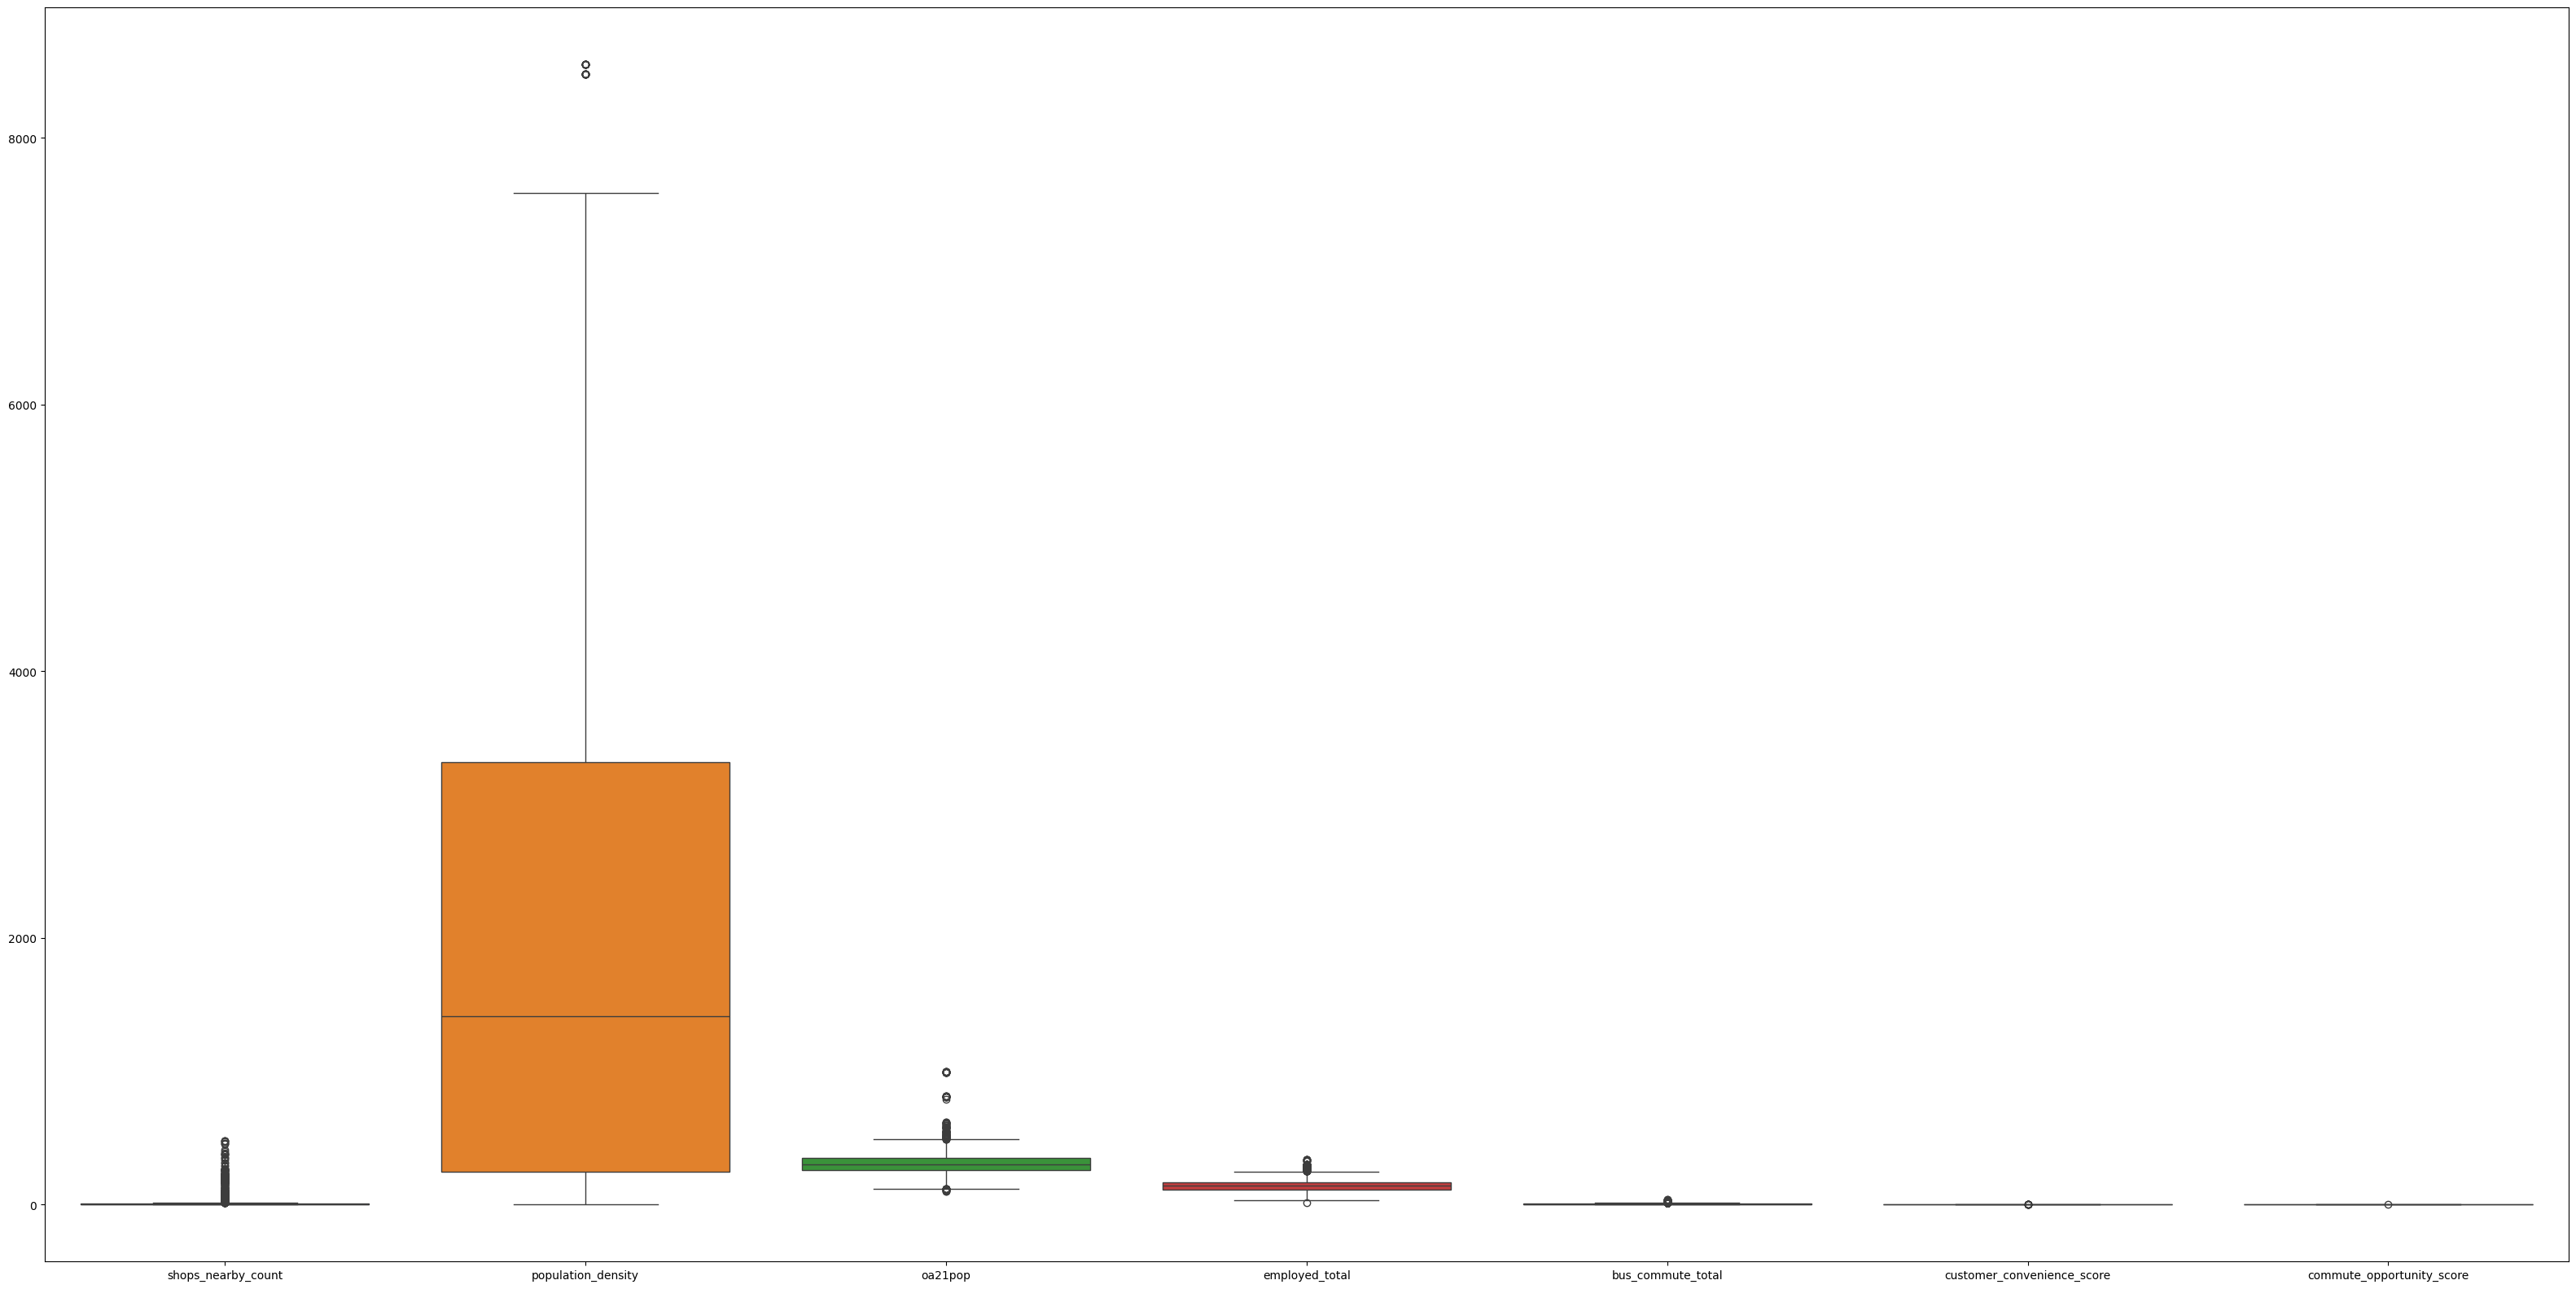

In [13]:
plt.figure(figsize=(40,20))
sns.boxplot(data=X_clean)

## 2.2 Normalize Data

In [14]:
scaler = MinMaxScaler()

X_normalized_np = scaler.fit_transform(X_clean)
X_normalized = pd.DataFrame(X_normalized_np, columns=columns_)
X_normalized.head()

,shops_nearby_count,population_density,oa21pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,0.002096,0.315334,0.173526,0.372308,0.000000,0.304027,0.438838
1,0.002096,0.315334,0.173526,0.372308,0.000000,0.301999,0.438838
2,0.027254,0.318930,0.143493,0.264615,0.228571,0.599797,0.731746
3,0.031447,0.760571,0.305895,0.363077,0.228571,0.668453,0.757025
4,0.002096,0.009895,0.248053,0.507692,0.000000,0.205388,0.464536


## 2.3 View normalized data to ensure no bias

<Axes: >

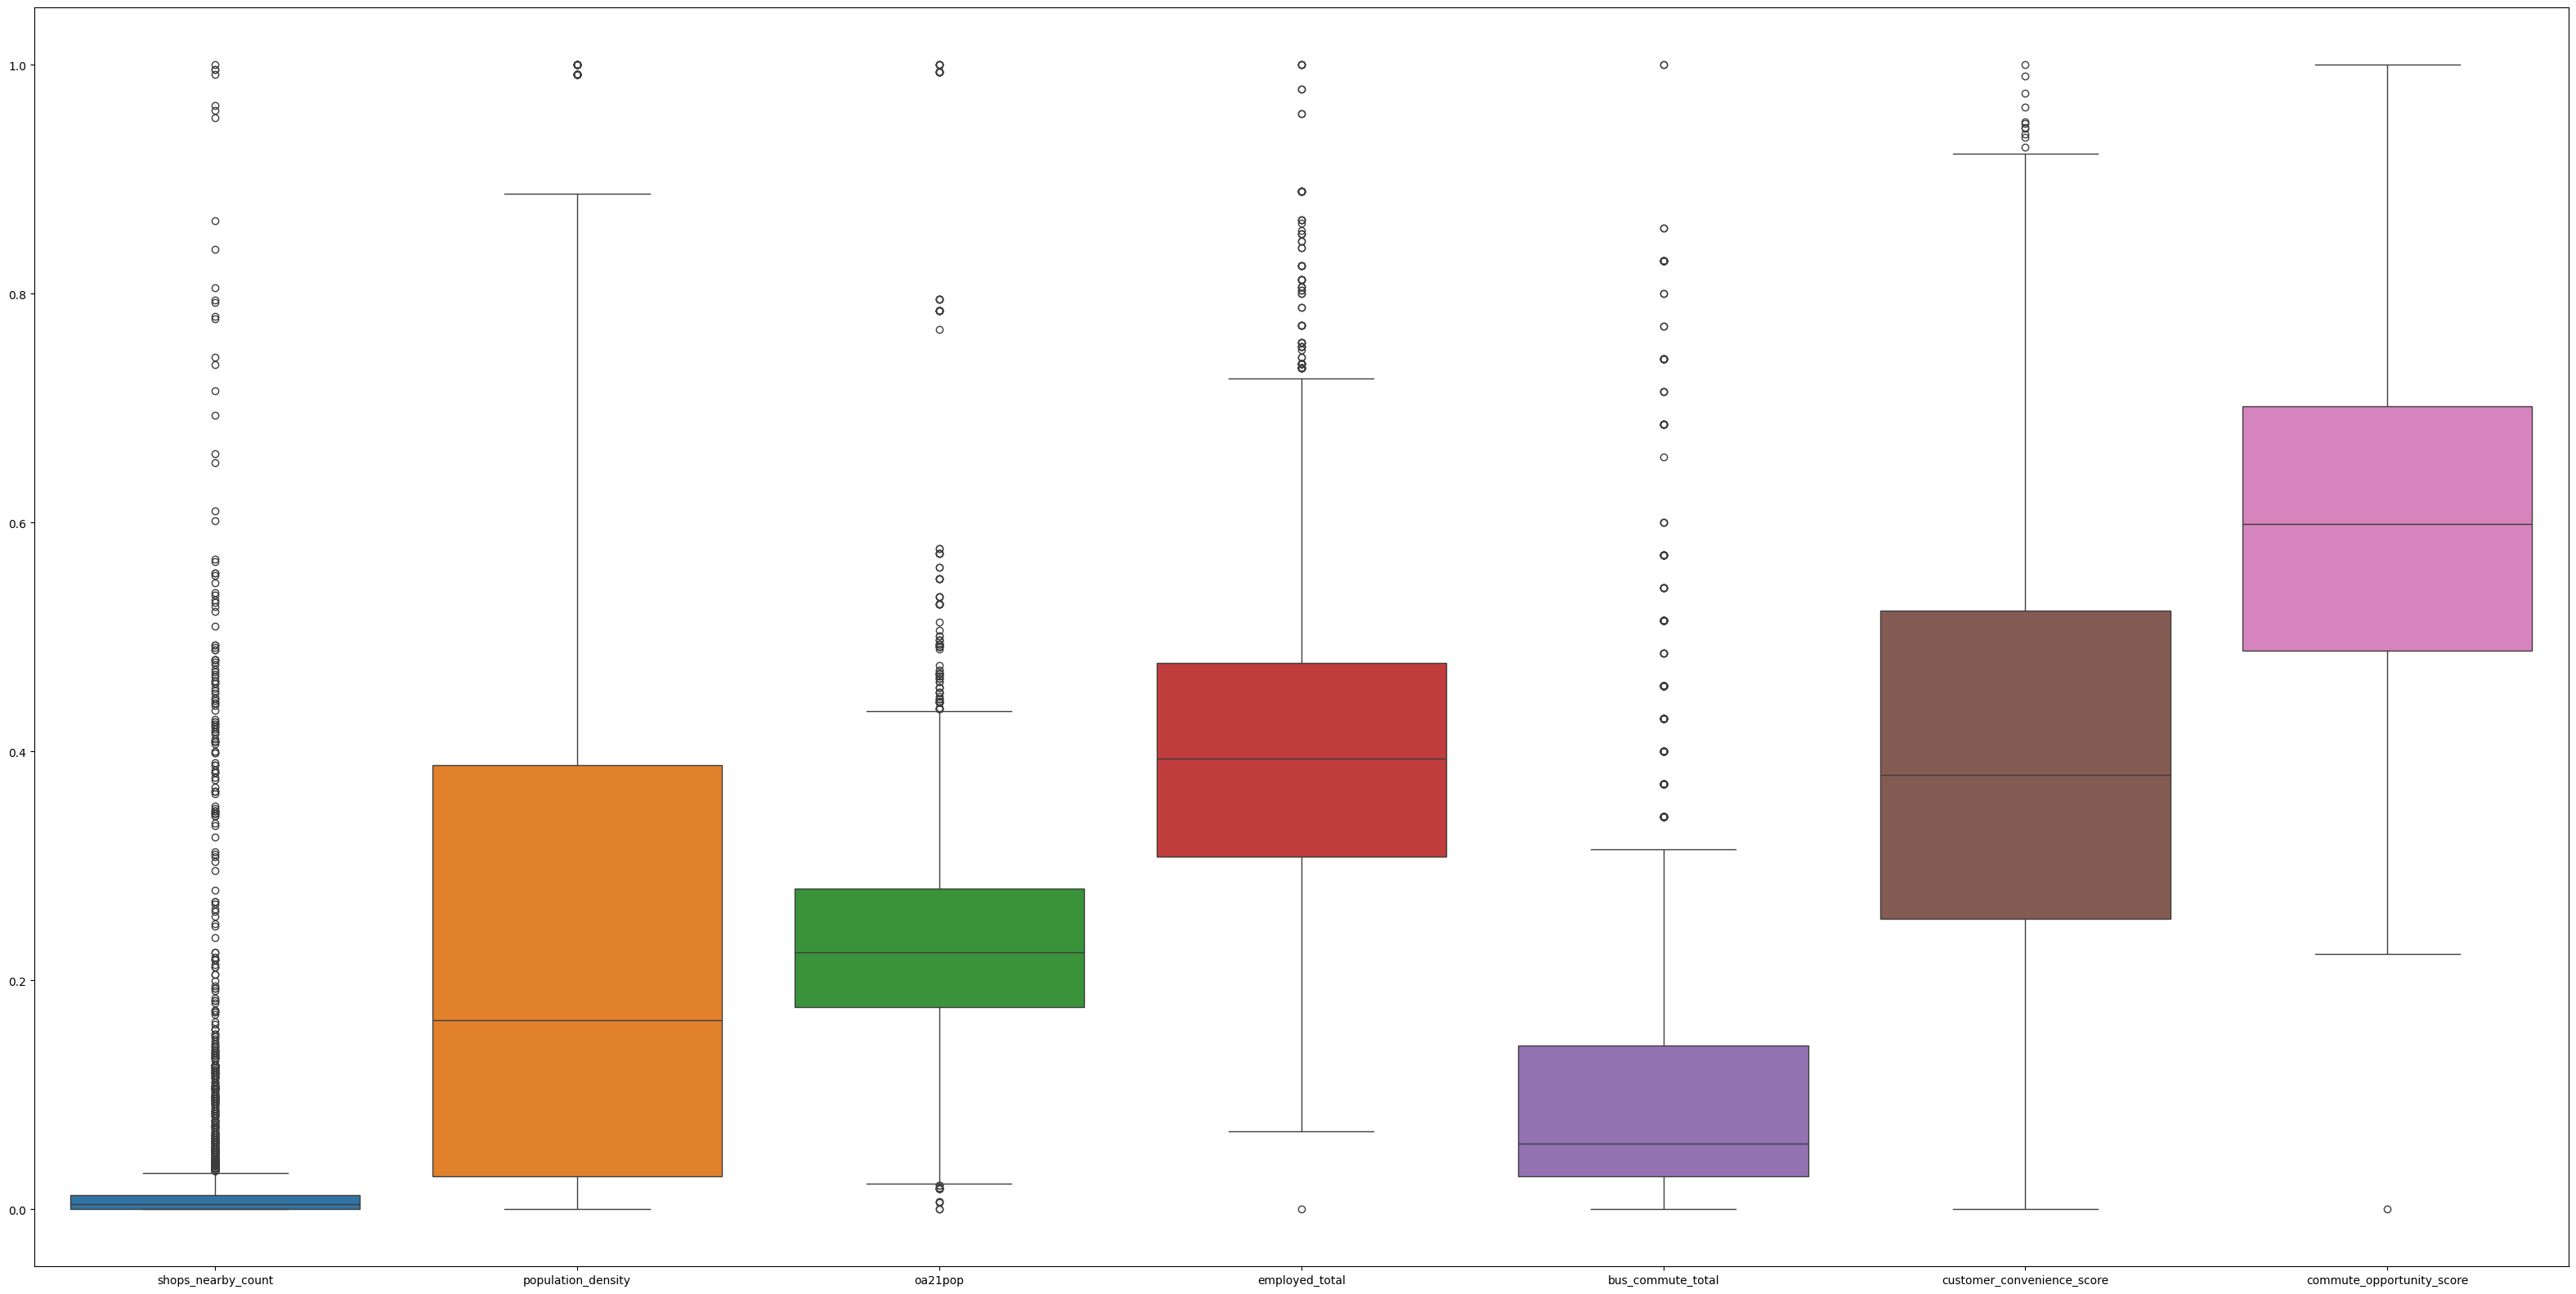

In [15]:
plt.figure(figsize=(40,20))
sns.boxplot(data=X_normalized)

## 2.4 80-20 Data Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)

## 2.5 Fitting the Multiple Linear Regression Model

In [17]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

## 2.6 Mapping Predicted v Actual Values

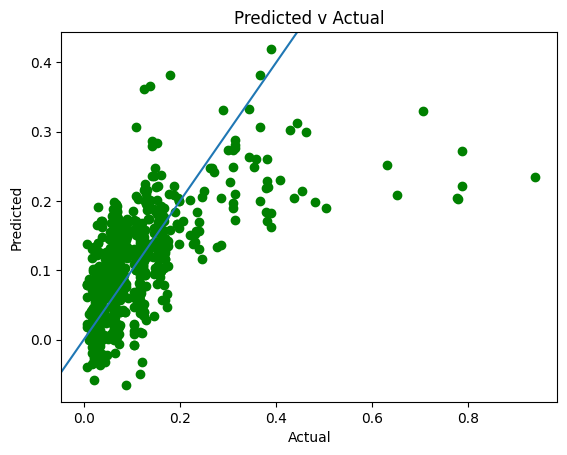

In [18]:
y_pred = regressor.predict(X_test)

plt.scatter(y_test, y_pred,color='g') 
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)

plt.show()

## 2.7 Producing statistical test outputs

In [19]:
linear_mae = metrics.mean_absolute_error(y_test, y_pred)
linear_mse = metrics.mean_squared_error(y_test, y_pred)
linear_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', linear_mae)
print('Mean Squared Error:', linear_mse)
print('Root Mean Squared Error:', linear_rmse)

Mean Absolute Error: 0.05221897163479744
Mean Squared Error: 0.007001429881608992
Root Mean Squared Error: 0.083674547394109


## Polynomial Regression Model
## 2.8 Standardizing Data

In [20]:
scaler = StandardScaler()

X_standard_np = scaler.fit_transform(X_clean)
X_standard = pd.DataFrame(X_standard_np, columns=columns_)
X_standard.head()

,shops_nearby_count,population_density,oa21pop,employed_total,bus_commute_total,customer_convenience_score,commute_opportunity_score
0,-0.286557,0.342702,-0.609587,-0.223415,-0.748289,-0.520467,-1.230432
1,-0.286557,0.342702,-0.609587,-0.223415,-0.748289,-0.531640,-1.230432
2,-0.021977,0.358011,-0.903527,-1.004657,0.903855,1.109260,0.939078
3,0.022119,2.238483,0.685927,-0.290379,0.903855,1.487561,1.126318
4,-0.286557,-0.957829,0.119820,0.758717,-0.748289,-1.063975,-1.040097


I never ended up using the standardized data above as it had an adverse affect on the model.

## 2.9 80-20 Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)

## 2.10 Fitting the Polynomial Regression Model

In [22]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X_train)
regressor = LinearRegression()
regressor.fit(X_poly, y_train)

LinearRegression()

## 2.11 Mapping Predicted v Actual Values

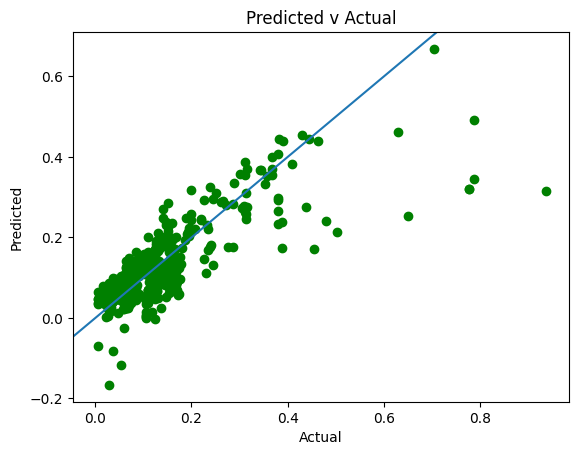

In [23]:
X_poly_test = poly_features.fit_transform(X_test)
y_pred = regressor.predict(X_poly_test)

plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.12 Producing Statistical test outputs

In [24]:
poly_mae = metrics.mean_absolute_error(y_test, y_pred)
poly_mse = metrics.mean_squared_error(y_test, y_pred)
poly_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) 
print('Mean Absolute Error:', poly_mae)
print('Mean Squared Error:', poly_mse)
print('Root Mean Squared Error:', poly_rmse)

Mean Absolute Error: 0.03732191349238782
Mean Squared Error: 0.0038181655833498763
Root Mean Squared Error: 0.061791306697219765


## Neural Network Model

## 2.13 Split Data into train, test, and validation sets

In [25]:
X_new, X_test, y_new, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

## 2.14 Using a linear output (essentially linear regression)

In [26]:
model = Sequential([
    Dense(1, activation='linear', input_shape=(7,)),
])
optimizer = "sgd"
model.compile(optimizer= optimizer,
              loss='mean_squared_error')

hist = model.fit(X_train, y_train,
          batch_size=128, epochs=150,
          validation_data=(X_dev, y_dev))



Epoch 1/150

18/18 [==============================] - 0s 7ms/step - loss: 0.3066 - val_loss: 0.1417
Epoch 2/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0922 - val_loss: 0.0481
Epoch 3/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0241
Epoch 4/150
18/18 [==============================] - 0s 2ms/step - loss: 0.0217 - val_loss: 0.0179
Epoch 5/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0178 - val_loss: 0.0161
Epoch 6/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0166 - val_loss: 0.0156
Epoch 7/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0161 - val_loss: 0.0153
Epoch 8/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0159 - val_loss: 0.0151
Epoch 9/150
18/18 [==============================] - 0s 3ms/step - loss: 0.0157 - val_loss: 0.0149
Epoch 10/150
18/18 [==============================] - 0s 2ms/step - loss: 0.0155 - val_loss: 0.0148
Epoch 

## 2.15 Modelling the reduction in MSE over each epoch

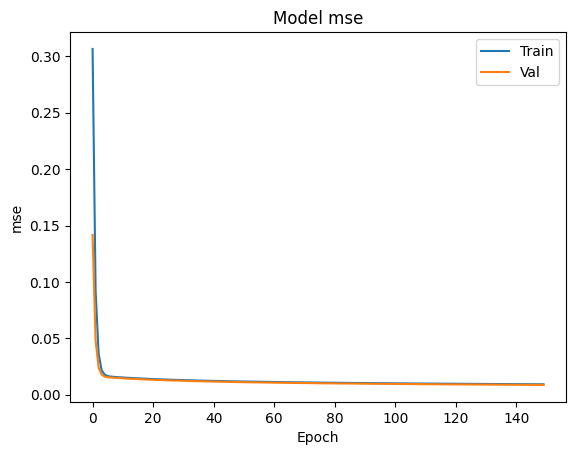

In [27]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## 2.16 Predicted v Actual values

24/24 [==============================] - 0s 589us/step


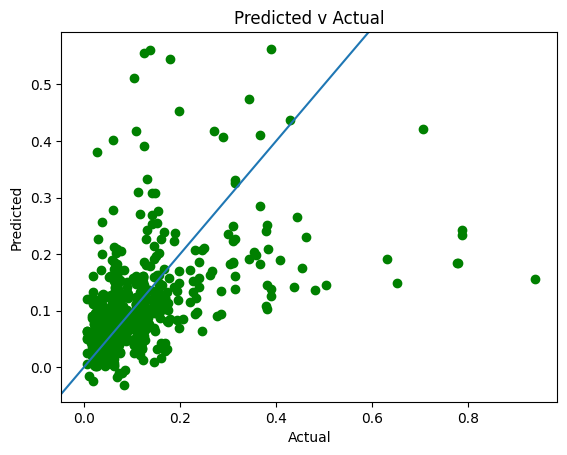

In [28]:
y_pred =  model.predict(X_test)
plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.17 Producing Statistical Tests

In [29]:
neural_linear_mae = metrics.mean_absolute_error(y_test, y_pred)
neural_linear_mse = metrics.mean_squared_error(y_test, y_pred)
neural_linear_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', neural_linear_mae)
print('Mean Squared Error:', neural_linear_mse)
print('Root Mean Squared Error:', neural_linear_rmse)

Mean Absolute Error: 0.05768616541186132
Mean Squared Error: 0.009466677343474077
Root Mean Squared Error: 0.09729685166270323


## 2.18 Producing a more complex neural net

In [30]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(7,)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam',
              loss='mean_squared_error')

hist = model.fit(X_train, y_train,
                 batch_size=128, epochs=50,
                 validation_data=(X_dev, y_dev))

Epoch 1/50
18/18 [==============================] - 1s 9ms/step - loss: 0.0286 - val_loss: 0.0191
Epoch 2/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0145
Epoch 3/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0143 - val_loss: 0.0117
Epoch 4/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0121 - val_loss: 0.0107
Epoch 5/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0116 - val_loss: 0.0104
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0111 - val_loss: 0.0101
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0108 - val_loss: 0.0097
Epoch 8/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0103 - val_loss: 0.0091
Epoch 9/50
18/18 [==============================] - 0s 4ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 10/50
18/18 [==============================] - 0s 3ms/step - loss: 0.0092 - val_loss: 0.0081
Epoch 11/50
18/18 [

## 2.19 Modelling the reduction of MSE over each epoch

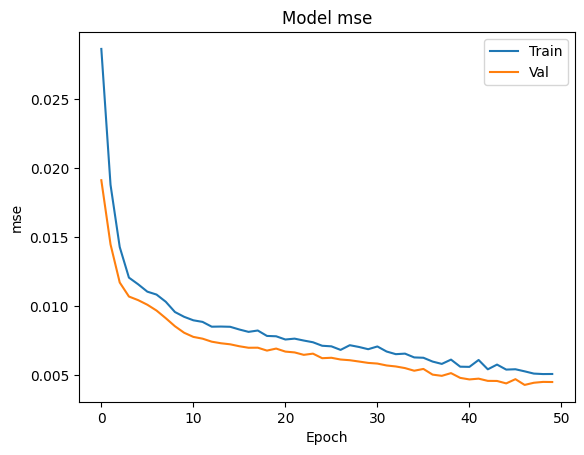

In [31]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model mse')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

## 2.20 Predicted v Actual values

24/24 [==============================] - 0s 1ms/step


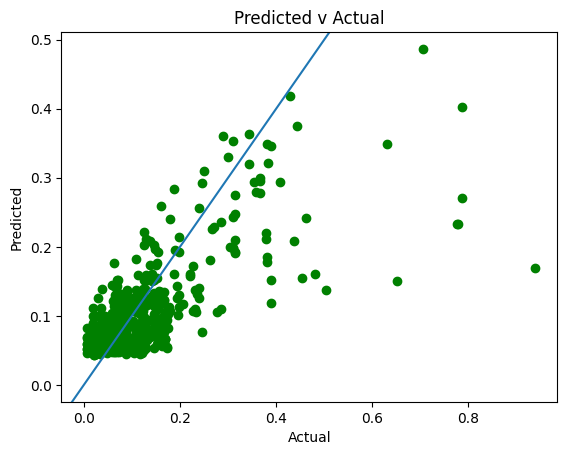

In [32]:
y_pred =  model.predict(X_test)
plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.21 Producing Statistical Tests

In [33]:
neural_net_mae = metrics.mean_absolute_error(y_test, y_pred)
neural_net_mse = metrics.mean_squared_error(y_test, y_pred)
neural_net_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.041168570846103224
Mean Squared Error: 0.005437183314511662
Root Mean Squared Error: 0.07373725865877889


## Gradient Boosting Regressor

## 2.22 Fit model using standardized data

In [34]:
model = GradientBoostingRegressor(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_standard, y_normalized, test_size=0.2, random_state=0)
model.fit(X_train, y_train)

GradientBoostingRegressor(random_state=0)

## 2.24 Plot predicted v actual values

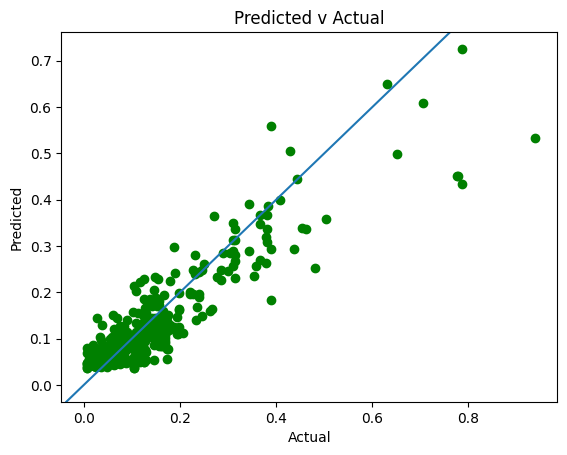

In [35]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred,color='g')
plt.title('Predicted v Actual')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.axline((0, 0), slope=1)
plt.ticklabel_format(style='plain')
plt.show()

## 2.25 Produce MAE, MSE, RMSE

In [36]:
gb_mae = metrics.mean_absolute_error(y_test, y_pred)
gb_mse = metrics.mean_squared_error(y_test, y_pred)
gb_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.030788239346351765
Mean Squared Error: 0.002211038109614035
Root Mean Squared Error: 0.047021677018307576


## 2.26 Compare MAE, MSE, and RMSE

In [37]:
tests_data = [['Linear Regression', linear_mae, linear_mse, linear_rmse], ["Polynomial Regression", poly_mae, poly_mse, poly_rmse], ["Linear Neural Net", neural_linear_mae, neural_linear_mse, neural_linear_rmse], ["Neural Network", neural_net_mae, neural_net_mse, neural_net_rmse], ["Gradient Boosting Regression", gb_mae, gb_mse, gb_rmse]]
tests_df = pd.DataFrame(tests_data, columns=['Model', 'MAE', 'MSE', 'RMSE'])
tests_df.head()

mae_ranked = tests_df.sort_values(by='MAE').head()
mse_ranked = tests_df.sort_values(by='MSE').head()
rmse_ranked = tests_df.sort_values(by='RMSE').head()
print("MAE Ranked:")
print(mae_ranked)
print("\nMSE Ranked:")
print(mse_ranked)
print("\nRMSE Ranked:")
print(rmse_ranked)

MAE Ranked:
                          Model       MAE       MSE      RMSE
4  Gradient Boosting Regression  0.030788  0.002211  0.047022
1         Polynomial Regression  0.037322  0.003818  0.061791
3                Neural Network  0.041169  0.005437  0.073737
0             Linear Regression  0.052219  0.007001  0.083675
2             Linear Neural Net  0.057686  0.009467  0.097297

MSE Ranked:
                          Model       MAE       MSE      RMSE
4  Gradient Boosting Regression  0.030788  0.002211  0.047022
1         Polynomial Regression  0.037322  0.003818  0.061791
3                Neural Network  0.041169  0.005437  0.073737
0             Linear Regression  0.052219  0.007001  0.083675
2             Linear Neural Net  0.057686  0.009467  0.097297

RMSE Ranked:
                          Model       MAE       MSE      RMSE
4  Gradient Boosting Regression  0.030788  0.002211  0.047022
1         Polynomial Regression  0.037322  0.003818  0.061791
3                Neural Network